In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import json
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("project_style.mplstyle")

import stats
import scipy.stats
from tqdm import tqdm
import analysis_tools as tools

In this notebook, we will consider a trained model, and analyze whether the model performs remapping or not

## Test dataset
We verify that the model generalizes to unseen data by simply creating a new dataset. 
The dataset consists of three separate, 10k timestep trajectories in three environments.
The environment sequence is square, walled square and a return to square, similar to the experiment performed by Fyhn et al. (2007)

In [2]:
if trajectories := False:
    model_type = "RNN"
else:
    model_type = "FF"

In [3]:
# load model and specs
model_name = f"../models/al1_10_l2_0"
path = f"../models/{model_name}"
model, params = tools.load_model(path, device = "cpu", model_type = model_type)

In [4]:
print("Model Parameters: \n", json.dumps(params, indent = 5))

Model Parameters: 
 {
     "epochs": 100,
     "batch_size": 64,
     "lr": 0.0001,
     "al1": 10.0,
     "l2": 0,
     "nodes": 500,
     "outputs": 100,
     "reset_interval": 10,
     "context": true
}


In [5]:
sequence = ["square", "walled_square", "square"]
bins = [[32,32] for i in range(len(sequence))] # all environments are symmetric

In [6]:
x, r, v, c = tools.test_dataset(sequence, 20000, 
                                context = params["context"], 
                                device = "cpu",
                                trajectories = trajectories)

In [7]:
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds = model.inference(dataset)
pred_error = np.linalg.norm(preds - r, axis = -1)
mean_errors = np.mean(pred_error, axis = 1)[:,None]*np.ones((1,r.shape[1]))

In [8]:
burn_in = 500 # omit initial timesteps to avoid transition rates
ps = ps[:,burn_in:]
gs = gs[:,burn_in:]
r = r[:,burn_in:]
preds = preds[:,burn_in:]

In [9]:
p_ratemaps = stats.population_vector_ratemaps(ps, r, bins, smooth = True)
g_ratemaps = stats.population_vector_ratemaps(gs, r, bins, smooth = False)

### Ratemaps

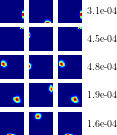

In [10]:
max_rates = np.nanmax(p_ratemaps, axis = (0,-2, -1))
tools.plot_sequence(p_ratemaps, show_units = 5, titles = max_rates,pane_size = 0.5);
#plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
#plt.savefig(f"./figures/{model_name}_global_remapping")

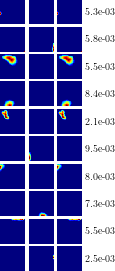

In [11]:
max_rates = np.amax(g_ratemaps, axis = (0, -2,-1))
mask = max_rates > 1e-6
select_g = g_ratemaps[:, mask]
tools.plot_sequence(select_g, show_units = 10, titles = max_rates[mask], pane_size = 0.5);
#tools.plot_sequence(g_ratemaps, show_units = 10,pane_size = 0.5);

plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
#plt.savefig(f"./figures/{model_name}_global_remapping_rnn")

Now we can prepare to correlate the two environments. However, we need to filter out cells that are place-cell like from those that are not. In addition, we only correlate a square cross-section of the circle and square cross-section:

In [12]:
mask, info = tools.spatial_information_selection(ps, r, bins);

/Users/m/Documents/jobb/phd/VPC/notebooks/stats.py:93: RuntimeWarning: divide by zero encountered in log2
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))
/Users/m/Documents/jobb/phd/VPC/notebooks/stats.py:93: RuntimeWarning: invalid value encountered in multiply
  spatial_information = np.nansum(occupancy*mean_bin_rate*np.log2(mean_bin_rate/mean_rate[:,None,None]), axis = (1, 2))


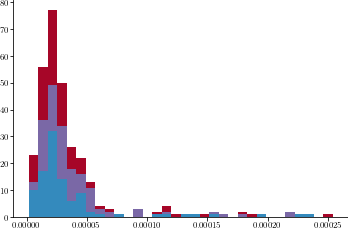

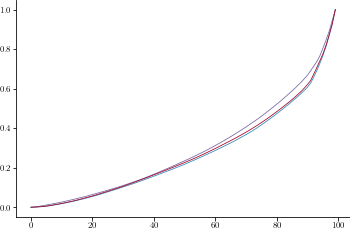

In [13]:
plt.hist(info.T, stacked = True, bins = 32);
plt.show()
plt.plot(np.cumsum(np.sort(info/np.sum(info,axis=-1)[:,None],axis=-1), axis= -1).T)
plt.show()

In [14]:
print("No. accepted cells:", np.sum(mask))

No. accepted cells: 78


In [15]:
# Only accept cells with high spatial information in overlap region.
accepted_maps = p_ratemaps[:, mask]

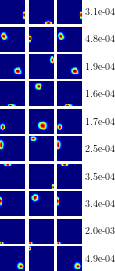

In [16]:
max_rates = np.amax(accepted_maps, axis = (0, -2, -1))
tools.plot_sequence(accepted_maps, show_units = 10, titles = max_rates, pane_size = 0.5);
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
#plt.savefig(f"./figures/{model_name}_global_remapping_high_spatial_information")

### Statistics

In [17]:
# correlate initial environment with all others
orientations = np.array([90*i for i in range(4)]) # Degrees 🔪
corrs = np.zeros((len(sequence),len(orientations), accepted_maps.shape[1], accepted_maps.shape[1]))

for i in range(len(sequence)):
    # do correlation
    for j in range(len(orientations)):
        rotated_ratemaps = scipy.ndimage.rotate(accepted_maps[i], orientations[j], axes = (1, 2))
        corrs[i,j] = stats.correlate_population_vectors_unitwise(accepted_maps[0], rotated_ratemaps)

In [18]:
self_correlation = np.diagonal(corrs, axis1 = 2, axis2 = 3)
median_self_correlation = np.median(self_correlation, axis = -1)
angle_inds = np.argmax(median_self_correlation, axis = 1)
maximal_angle = orientations[angle_inds]

# only keep angle that maximises median correlation
self_correlation = self_correlation[np.arange(len(sequence)), angle_inds]
median_self_correlation = median_self_correlation[np.arange(len(sequence)), angle_inds]
mean_self_correlation = np.mean(self_correlation, axis = -1)
corrs = corrs[np.arange(len(sequence)), angle_inds]

print(f"Maximal median correlation angles: {maximal_angle}", self_correlation.shape)

Maximal median correlation angles: [0 0 0] (3, 78)


### Cell-to-cell ratemap correlation + Mann Whitney U test for significance. 

In [19]:
# Only the upper triangular contributes to the test result
triu_mask = np.ravel(np.triu(np.ones(corrs.shape[1:],dtype="bool"), k = 1)) 

# and flatten to mask out correct entries
flat_dist = np.reshape(corrs, (len(sequence), -1))
distribution = flat_dist[:,triu_mask]

median_correlations = np.median(np.amax(self_correlation, axis = 1), axis = -1)

# finally, do MW-U to test significance.
res, p_value = scipy.stats.mannwhitneyu(self_correlation, distribution, axis = -1, alternative = "two-sided")
# test alternative hypothesis: whether self_correlation is greater than shuffled distribution

#results_file.write(f"\n\nMedian Correlations\n{median_correlations}\nU ={res}\np={p_value}\n")
print(f"\n\n\nP-values: {p_value[1]*100:.3f}%, {p_value[2]*100:.3f}%\n\n")
print(p_value)




P-values: 0.317%, 0.000%


[1.62623452e-51 3.16500265e-03 1.62748632e-51]


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

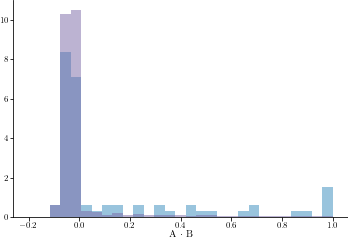

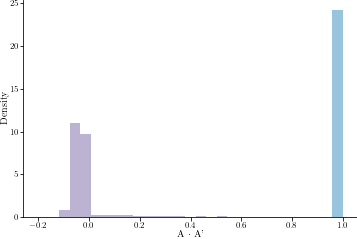

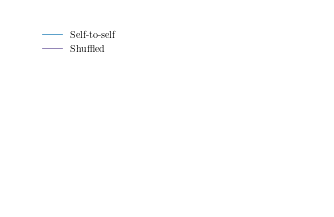

In [20]:
corr_symbol = '$\cdot$' 
seq_labels = ["A", "B", "A'"]

# plot distributions

hist_bins = np.linspace(-0.2, 1, 30)
for i in range(1, len(sequence)):
    plt.figure()
    plt.hist(self_correlation[i], alpha = 0.5, density = True, bins = hist_bins)
    plt.hist(distribution[i], alpha = 0.5, density = True, bins = hist_bins)
    plt.xlabel(f"{seq_labels[0]} {corr_symbol} {seq_labels[i]}")
    if i == 2:
        plt.ylabel("Density")

    #plt.savefig(f"./figures/{model_name}_global_remapping_spatial_correlation_{i}")

plt.figure()
plt.plot(0,0, 0,0)
plt.legend(["Self-to-self", "Shuffled"], bbox_to_anchor=(0.1, 0.9), loc='upper left', ncol=1)
plt.axis("off")
#plt.savefig(f"./figures/{model_name}_global_remapping_spatial_correlation_legend")

<ipython-input-21-79a61d5c26b6>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.bar(j-1, mean_self_correlation[j], color = matplotlib.cm.get_cmap("Blues")(0.3))


([<matplotlib.axis.XTick at 0x168ff8c40>,
 [Text(0, 0, 'A$\\cdot$B'), Text(1, 0, "A$\\cdot$A'")])

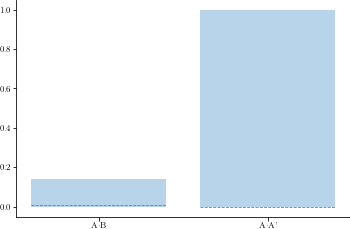

In [21]:

labels = []

for j in range(1, len(sequence)):
    labels.append(f"{seq_labels[0]}{corr_symbol}{seq_labels[j]}")
    plt.bar(j-1, mean_self_correlation[j], color = matplotlib.cm.get_cmap("Blues")(0.3))
    plt.hlines(np.mean(distribution[j]), (j-1.4), (j-0.6), linestyles = "dashed")

plt.xticks(np.arange(0, len(sequence)-1), labels)
#plt.tight_layout()

#plt.savefig(f"./figures/{model_name}_spatial_correlation_bar", bbox_inches = "tight")

### Rate overlap

In [22]:
mu_overlap = np.zeros(len(sequence))
sig_overlap = np.zeros(len(sequence))
n_active = np.zeros(len(sequence))
random_overlap = np.zeros(len(sequence))

for i in range(len(sequence)):
    mu_overlap[i], sig_overlap[i], n_active[i] = stats.rate_overlap(p_ratemaps[0], p_ratemaps[i])
    random_overlap[i] = stats.random_rate_overlap(p_ratemaps[0], p_ratemaps[i])

<ipython-input-23-bf8c6a7dc6ba>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.bar(j-1, mu_overlap[j], yerr = sig_overlap[j], color = matplotlib.cm.get_cmap("Oranges")(0.3))


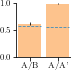

In [23]:
labels = []
symbol = "/"

for j in range(len(sequence)):
    if j > 0:
        labels.append(f"{seq_labels[0]}{symbol}{seq_labels[j]}")
        plt.bar(j-1, mu_overlap[j], yerr = sig_overlap[j], color = matplotlib.cm.get_cmap("Oranges")(0.3))
        plt.hlines(random_overlap[j], (j-1.4), (j-0.6), linestyles = "dashed")
plt.xticks(np.arange(len(sequence)-1), labels, rotation = 0)
plt.ylim(0, 1)
plt.gcf().set_size_inches(1,1)
#plt.savefig(f"./figures/{model_name}_rate_overlap_bar", bbox_inches = "tight")


<ipython-input-24-4b01c42d508c>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.bar(j-1, mean_self_correlation[j], color = matplotlib.cm.get_cmap("Blues")(0.3))


([<matplotlib.axis.XTick at 0x16914be20>,
 [Text(0, 0, 'A$\\cdot$B'), Text(1, 0, "A$\\cdot$A'")])

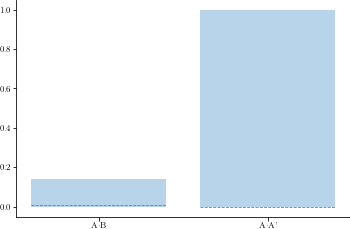

In [24]:

labels = []

for j in range(1, len(sequence)):
    labels.append(f"{seq_labels[0]}{corr_symbol}{seq_labels[j]}")
    plt.bar(j-1, mean_self_correlation[j], color = matplotlib.cm.get_cmap("Blues")(0.3))
    plt.hlines(np.mean(distribution[j]), (j-1.4), (j-0.6), linestyles = "dashed")

plt.xticks(np.arange(0, len(sequence)-1), labels)
#plt.ylim(-0.05, 1.1)
#plt.savefig(f"./figures/{model_name}_spatial_correlation_bar")

In [25]:
pop_corr = np.zeros((len(sequence), p_ratemaps.shape[-2], p_ratemaps.shape[-1]))

for i in range(1, len(sequence)):
    for j in range(32):
        for k in range(32):
            pop_corr[i, j, k] = np.corrcoef(p_ratemaps[0,:,j,k], p_ratemaps[i,:,j,k])[0,1]

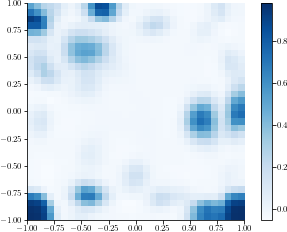

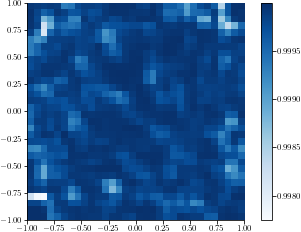

In [26]:
lims = [-1, 1, -1, 1]
for i in range(1, len(sequence)):
    plt.figure()
    plt.imshow(pop_corr[i], extent = lims)#, vmin = np.amin(pop_corr), vmax = np.amax(pop_corr))
    plt.colorbar(pad = 0.05, fraction = 0.045)
    #plt.savefig(f"./figures/{model_name}_spatial_correlation_space_{i}", bbox_inches = "tight")
    